confusion matrix :
    http://gcucurull.github.io/caffe/python/deep-learning/2016/06/29/caffe-confusion-matrix/
    https://github.com/gcucurull/caffe-conf-matrix
FCN :
    score :
        https://github.com/shelhamer/fcn.berkeleyvision.org/blob/master/score.py
    infer :
        https://github.com/shelhamer/fcn.berkeleyvision.org/blob/master/infer.py

In [24]:
from __future__ import division
from __future__ import print_function
import caffe
import _init_paths
import numpy as np
import os
import sys
from datetime import datetime
from PIL import Image as pilimage
from IPython.display import Image
from IPython.display import clear_output
import time
from matplotlib.pyplot import imshow
from matplotlib.pyplot import imread
from matplotlib.pyplot import imsave
%matplotlib inline

In [2]:
def log_progress(sequence, title='', every=1, size=None, end_msg='', removeAtTheEnd=False):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{index} / ?'.format(index=index)
                else:
                    progress.value = index
                    if isinstance(sequence, dict):
                        val = ''
                    else:
                        val=sequence[index-1]
                            
                    label.value = u'{title} : {value} ({index} / {size})'.format(
                        title=title,
                        value=val,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = end_msg
        if removeAtTheEnd:
            box.close()
    

In [3]:
#newParams = {}

## classes
#newParams['classes_file_path']= '/home/jogue/workspace/datasets/SUNRGBD_pv/37_classes.txt'

## images
#newParams['images_folder']= '/home/jogue/workspace/datasets/SUNRGBD_pv/data/rgb_i_100_8bits/'
#newParams['image_file_extension']= 'png'
## segmentations
#newParams['segmentations_folder']= '/home/jogue/workspace/datasets/SUNRGBD_pv/data_nyudv2/labels_segmentation_37d_range_10-10-100/testGupta/'                            
#newParams['segmentation_file_extension']= 'png'

##sets
#newParams['set_file_path']= '/home/jogue/workspace/datasets/SUNRGBD_pv/data/sets/nyudv2_gupta/testGupta_10-10-100.txt'

## shuffle
#newParams['shuffle']= False

In [4]:
ICIPmodels = '/home/jogue/workspace/ICIPmodels/'
prototxt_path = ICIPmodels+'jg_test.prototxt'
caffe_gpu = True
if not caffe_gpu:
    caffe.set_mode_cpu()
else:
    caffe.set_mode_gpu()
    caffe.set_device(0);

In [5]:
net = caffe.Net(prototxt_path, caffe.TEST)
#net = caffe.Net(prototxt_path,weights_path , caffe.TEST)

Number of image : 654
Separated in 37 classes : {'toilet': 32, 'whiteboard': 29, 'wall': 0, 'night_stand': 31, 'books': 22, 'mirror': 18, 'table': 6, 'chair': 4, 'floor': 1, 'tv': 24, 'lamp': 34, 'window': 8, 'curtain': 15, 'blinds': 12, 'dresser': 16, 'picture': 10, 'ceiling': 21, 'door': 7, 'shower_curtain': 27, 'fridge': 23, 'cabinet': 2, 'sink': 33, 'desk': 13, 'bookshelf': 9, 'towel': 26, 'box': 28, 'floor_mat': 19, 'shelves': 14, 'sofa': 5, 'counter': 11, 'bed': 3, 'person': 30, 'paper': 25, 'bag': 36, 'bathtub': 35, 'pillow': 17, 'clothes': 20}


#### Blobs & Layers

In [6]:
B = [(k, v.data.shape) for k, v in net.blobs.items()]
L = [(k, v[0].data.shape, v[1].data.shape) for k, v in net.params.items() if k != 'upscore37']

#### Updating with new params

In [7]:
Cases = {}

Cases['DHA']={}
Cases['DHA']['weights'] = '/home/jogue/soft/digits/digits/jobs/20170206-020136-4752/snapshot_iter_15900.caffemodel'
Cases['DHA']['dataset'] = '/home/jogue/workspace/datasets/ONERA.ROOM.extraits/data/d_raw_DHA_8bits/'
Cases['DHA']['set_file_path'] = '/home/jogue/workspace/datasets/ONERA.ROOM.extraits/data/sets/eval.txt'
Cases['DHA']['results']=[]

Cases['RGB']={}
Cases['RGB']['weights'] = '/home/jogue/soft/digits/digits/jobs/20170204-030454-4515/snapshot_iter_15900.caffemodel'
Cases['RGB']['dataset'] = '/home/jogue/workspace/datasets/ONERA.ROOM.extraits/data/rgb_i_100_8bits/'
Cases['RGB']['set_file_path'] = '/home/jogue/workspace/datasets/ONERA.ROOM.extraits/data/sets/eval.txt'
Cases['RGB']['results']=[]

In [30]:
for case in log_progress(Cases.keys(),title='Model', end_msg='Finished !'): 
        weights_path = Cases[case]['weights']
        net.copy_from(weights_path)
        newParams = {}
        newParams['images_folder']= Cases[case]['dataset']
        newParams['set_file_path']= Cases[case]['set_file_path']
        newParams['iter_counter']=0
        newParams['countEpoch']=0
        net.layers[0].update(newParams)
        
        results = []
        losses = []
        segmentations = []
        
        n_cl = net.blobs['score'].channels
        hist = np.zeros((n_cl, n_cl))
        loss = 0
        print("###############################################################")
        print("NEW TESTING : model",case)
        #for idx in log_progress(range(net.layers[0].nb_images), title='iteration', end_msg=str(i),removeAtTheEnd=True):
        for idx in log_progress(range(net.layers[0].nb_images), title='iteration', removeAtTheEnd=True):
            net.forward()
            score_map = net.blobs['score'].data[0].argmax(0)
            imsave('/home/jogue/workspace/datasets/ONERA.ROOM.extraits/data/results_seg/'+str(idx+1)+'_'+case+'.seg.png',score_map)
            results.append(score_map)
        Cases[case]['results']=results

###############################################################
NEW TESTING : model RGB
New epoch [total epoch : 1 ].
###############################################################
NEW TESTING : model DHA
New epoch [total epoch : 1 ].


In [ ]:
Image

In [ ]:
data

In [ ]:
data.shape

In [20]:
data = 6*Cases['RGB']['results'][0].astype(np.uint8)
img = pilimage.fromarray(data,'L')
#img.save('my.png')
img.show()

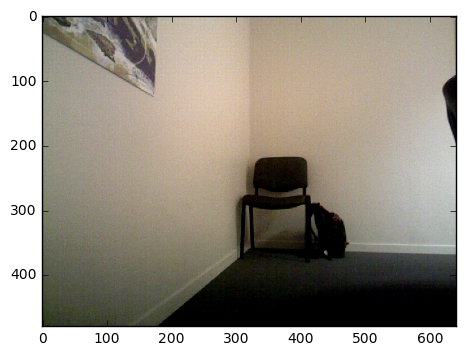

In [19]:

imshow(imread('/home/jogue/workspace/datasets/ONERA.ROOM.extraits/data/rgb_i_100_8bits/00001.png'))

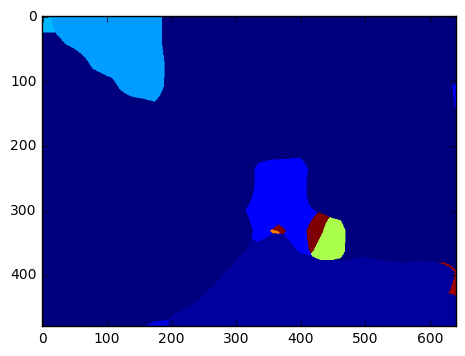

In [21]:
imshow(data)